In [17]:
from pandas import set_option
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import optuna
warnings.filterwarnings("ignore")

from imblearn.over_sampling import SMOTE,BorderlineSMOTE
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split,KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix,auc,roc_curve,classification_report,accuracy_score,make_scorer,recall_score

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectFromModel

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,VotingClassifier,HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

df = pd.read_csv('uci-secom.csv')
df

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2008-10-16 15:13:00,2899.41,2464.36,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.3424,...,203.1720,0.4988,0.0143,0.0039,2.8669,0.0068,0.0138,0.0047,203.1720,-1
1563,2008-10-16 20:49:00,3052.31,2522.55,2198.5667,1124.6595,0.8763,100.0,98.4689,0.1205,1.4333,...,NaN,0.4975,0.0131,0.0036,2.6238,0.0068,0.0138,0.0047,203.1720,-1
1564,2008-10-17 05:26:00,2978.81,2379.78,2206.3000,1110.4967,0.8236,100.0,99.4122,0.1208,NaN,...,43.5231,0.4987,0.0153,0.0041,3.0590,0.0197,0.0086,0.0025,43.5231,-1
1565,2008-10-17 06:01:00,2894.92,2532.01,2177.0333,1183.7287,1.5726,100.0,98.7978,0.1213,1.4622,...,93.4941,0.5004,0.0178,0.0038,3.5662,0.0262,0.0245,0.0075,93.4941,-1


In [22]:
df = df.drop(['Time'],axis=1)

## Remove the feature with more than 90% of null values

In [23]:
missing= df.isnull().sum().reset_index().rename(columns={0:'missNum'})
missing['missRate']=missing['missNum']/df.shape[0]
empty = missing[missing['missRate']>0.9]['index'].values
df = df.drop(empty,axis=1)
print(df.shape)

(1567, 587)


## Imputation

In [24]:
knn =  KNNImputer(n_neighbors=3)
impute = knn.fit_transform(df)
df_impute = pd.DataFrame(impute, columns = df.columns)

In [25]:
df_impute['Pass/Fail'] = df_impute['Pass/Fail'].replace({1:'1'})
df_impute['Pass/Fail'] = df_impute['Pass/Fail'].replace({-1:'0'})
df_impute['Pass/Fail'] = df_impute['Pass/Fail'].astype(int)

df_feature = df_impute.drop(['Pass/Fail'],axis = 1)
df_label = df_impute['Pass/Fail']

In [26]:
print(df_label.value_counts())

0    1463
1     104
Name: Pass/Fail, dtype: int64


## Addressing Outliers
Outliers are identified and replaced by median value of the corresponding feature.

In [27]:
def outliers(df):
    features = df.columns
    for j in features:
        Q1 = df[j].quantile(q=0.25)
        Q2 = df[j].median()
        Q3 = df[j].quantile(q=0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + 1.5*IQR
        lower_bound = Q1 - 1.5*IQR
        for i in range(0,df.shape[0]):
            if(df[j][i] > upper_bound or df[j][i]<lower_bound):
                df[j][i] = df[j].median()
    return df

df_feature = outliers(df_feature)

## Check Multi-collinearity problem

Checking for **correlated independent** features using correlation matrix. The threshold is selected as 0.80. If two features are correlated by coefficient>0.8, one of the correlated feature is removed.  

In [28]:
def remove_corr(df, threshold):
    corr = pd.DataFrame(abs(df.corr()))

    Featurei = []
    Featurej = []
    Corr = []

    for i in corr.index:
        for j in corr.columns:
            if (corr.loc[i, j] > threshold and i != j):
                if(i not in Featurei):
                    Featurei.append(i)
                if(j not in Featurej):
                    Featurej.append(j)
                    Corr.append(corr.loc[i, j])

    d = pd.DataFrame([Featurei, Featurej, Corr]).transpose()
    d.columns = ['feature1','feature2','correlation']
    display(d)
    to_drop = set(d['feature1'])
    print('Number of features removed = ', len(to_drop))

    return (df.drop(to_drop, axis=1))
df_feature = remove_corr(df_feature, 0.80)

,feature1,feature2,correlation
0,11,147,0.902877
1,12,282,0.904849
2,17,420,0.906577
3,18,18,0.980611
4,21,153,0.891689
...,...,...,...
323,583,584,0.831048
324,584,585,0.996439
325,585,583,0.831048
326,587,588,0.851673


Number of features removed =  328


Checking for **Variance Inflation Factor (VIF)** of each independent feature. Features with VIF>5 are removed.  

The **Variance Inflation Factor (VIF)** is a numerical value that represents the degree of collinearity between observations of an independent variable.  
A VIF greater than 5 is considered multicollinearity.

In [29]:
def remove_high_VIF(df, limit):
    vif = pd.DataFrame()
    high_vif = []
    vif['features'] = df.columns
    vif['VIF'] = [VIF(df.values,i) for i in range(len(df.columns))]
    display(vif)
    high_vif= vif[vif['VIF']>limit].features
    print('Number of features with VIF > ',limit,'= ',len(high_vif))
    return(df.drop(high_vif,axis=1))

df_feature = remove_high_VIF(df_feature,5)

,features,VIF
0,0,1.153540
1,1,1.134100
2,2,2.202149
3,3,2.544339
4,4,1.324274
...,...,...
253,578,1.537939
254,581,1.469631
255,582,1.220128
256,586,1.454787


Number of features with VIF >  5 =  3


Features with very low variance will not have predicitve power. Thus, features with very low variance are detected and dropped.  
Variance Threshold is calculated as (0.8*(1-0.8))

In [30]:
def remove_variance(df,thres):
    # set_option('precision', 3)
    sel = VarianceThreshold(threshold=(thres * (1 - thres)))
    var_df = pd.DataFrame({'Name':df.columns,'Var':sel.fit(df).variances_})
    display(pd.DataFrame({'Name':df_feature.columns,'Var':np.round(sel.fit(df_feature).variances_,3).astype(str)}))
    dummy = var_df['Name'].where(var_df['Var']<(thres * (1 - thres)))
    dummy = dummy.dropna()
    print('Number of features removed: ',len(dummy))
    return(dummy)

df_feature = df_feature.drop(remove_variance(df_feature,0.80),axis=1)

,Name,Var
0,0,3838.65
1,1,3550.195
2,2,661.589
3,3,112323.602
4,4,0.111
...,...,...
250,578,0.0
251,581,1354.308
252,582,0.0
253,586,0.0


Number of features removed:  189


## Feature selection

Using XGBoost to further select the best features.

In [31]:
def imp_features(X, y):
    model = XGBClassifier()
    model.fit(X,y)
    fi_df = pd.DataFrame({'Name':pd.Series(model.feature_names_in_),'FI':pd.Series(model.feature_importances_)})
    dummy = fi_df['Name'].where(fi_df['FI']>0.01)
    dummy = dummy.dropna()
    display(fi_df.sort_values(by='FI',ascending=False))
    print('Number of features with ''feature importance'' greater than 0.01 :',len(dummy))
    return(dummy)

imp_features = imp_features(df_feature,df_label)
df_feature = df_feature[imp_features]

,Name,FI
18,59,0.028917
57,500,0.028818
56,499,0.027283
15,41,0.026798
31,129,0.025274
...,...,...
19,63,0.005721
50,484,0.004655
53,487,0.004453
63,570,0.002443


Number of features with feature importance greater than 0.01 : 51


### Normalize data

In [32]:
scaler =  MinMaxScaler()
scaled_feature = scaler.fit_transform(df_feature)
scaled_feature = pd.DataFrame(scaled_feature,columns=df_feature.columns)
scaled_feature

,0,1,2,14,16,22,23,28,32,39,...,486,488,489,499,500,510,547,548,562,581
0,0.555185,0.699396,0.425333,0.404266,0.586232,0.700024,0.456790,0.233642,0.049837,0.206549,...,0.843543,0.053242,0.000000,0.000000,0.000000,0.601492,0.179573,0.371708,0.292540,0.416064
1,0.735429,0.408160,0.722609,0.560050,0.233746,0.395167,0.593407,0.468534,0.400721,0.377807,...,0.130702,0.194921,0.000000,0.000000,0.000000,0.437687,0.671576,0.284025,0.555806,0.390176
2,0.281914,0.687436,0.416125,0.514774,0.258268,0.490359,0.455975,0.396259,0.366217,0.517505,...,0.747295,0.192235,0.328364,0.000000,0.000000,0.437687,0.758536,0.285129,0.692481,0.429521
3,0.437867,0.451642,0.504023,0.521115,0.428346,0.438125,0.338660,0.160744,0.401954,0.073921,...,0.104719,0.000000,0.442019,0.000000,0.712188,0.437687,0.512237,0.110708,0.749462,0.382780
4,0.558826,0.519311,0.743114,0.589188,0.719145,0.425433,0.470891,0.155137,0.731503,0.456705,...,0.000000,0.750039,0.000000,0.293140,0.000000,0.437687,0.341144,0.640120,0.205372,0.817843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,0.189638,0.405862,0.369622,0.674419,0.674601,0.398828,0.512690,0.621181,0.153001,0.456705,...,0.182552,0.317968,0.248631,0.000000,0.000000,0.494726,0.410325,0.483205,0.555806,0.390176
1563,0.614609,0.577287,0.500774,0.489717,0.669561,0.076153,0.549101,0.716508,0.204607,0.981958,...,0.000000,0.273391,0.385479,0.816364,0.875180,0.273791,0.374619,0.174736,0.681124,0.359146
1564,0.410323,0.156695,0.554627,0.598943,0.440165,0.495485,0.442188,0.628039,0.623755,0.313444,...,0.171036,0.382464,0.138449,0.456716,0.000000,0.509993,0.011084,0.245860,0.186607,0.225610
1565,0.177159,0.605155,0.350820,0.530339,0.505107,0.465707,0.467381,0.585668,0.320451,0.606866,...,0.130821,0.148023,0.159712,0.511340,0.433728,0.730110,0.374619,0.174736,0.555806,0.484644


## Split training data and testing data

Using a train-test split of 80%-20%.  
The split is stratified to maintain the same dependent class distribution for train and test data.

In [33]:
X_train,X_test,y_train,y_test = train_test_split(scaled_feature, df_label, test_size =0.2,stratify=df_label,random_state= 42)

## Oversampling
* Because the data is highly imbalance,we need to do data oversmapling
* Using Synthesized Minority Oversampling Technique(SMOTE) to upsampling the minority class data

In [34]:
print("before:")
print(y_train.value_counts())

oversample = BorderlineSMOTE(sampling_strategy=1)

X_train_over, Y_train_over = oversample.fit_resample(X_train, y_train)
#X_test, Y_test = oversample.fit_resample(X_test, Y_test)
traindata_over = X_train_over.copy()
traindata_over['label'] = Y_train_over
print("After Oversampling")
traindata_over['label'].value_counts()

before:
0    1170
1      83
Name: Pass/Fail, dtype: int64
After Oversampling


0    1170
1    1170
Name: label, dtype: int64

## Evaluation metric

* Confusion matrix
* AUC (Area Under Curve) : It represents the area under the ROC curve
* Sensitivity = TP/(TP + FN)
* Specificity = TN/(FP + TN)
* G - means  
G - means = sqrt(Sensitivity*Specificity)  
The G-mean index takes both sensitivity and specificity into consideration and is the harmonic average of both.Only when
the sensitivity and specificity are both large, G-mean will
increase.

* Matthews correlation coefficient (MCC)  
MCC = (TP * TN - FP * FN)/sqrt( (TN + FN)*(TN + FP)*(TP + FN)*(TP + FP) )  
the MCC index can comprehensively consider
sensitivity and specificity. When the data are extremely imbalanced, according to the definition of the MCC index, the MCC
is far less than sensitivity and specificity. T

In [35]:
def confusion_matrix_plot(cm):
  fig, ax = plt.subplots(figsize=(1.5, 1.5))
  ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(x=j, y=i, s=cm[i,j], va='center', ha='center')
  plt.xlabel('predicted label')
  plt.ylabel('true label')
  plt.show()

def Metric(y_true, y_pred, show_result=True ):
	cm = confusion_matrix(y_true, y_pred)
	TN = cm[0][0]
	FP = cm[0][1] # Type 1 error
	FN = cm[1][0] # Type 2 error
	TP = cm[1][1]
	Sensitivity = np.round( TP/(TP+FN) ,3) # recall
	Specificity = np.round( TN/(FP+TN) ,3)
	G_mean = np.round( np.sqrt(Sensitivity*Specificity) ,3)
	MCC = np.round( (TP * TN - FP * FN)/np.sqrt( (TN + FN)*(TN + FP)*(TP + FN)*(TP + FP) ) ,3)
	accuracy = np.round((TP + TN)/(TP+FP+FN+TN),3)
	fpr,tpr,threshold = roc_curve(y_true, y_pred)
	roc_auc = np.round( auc(fpr,tpr),3)

	if show_result:
		print(confusion_matrix_plot(cm))
		print('Accuracy =',accuracy,'|Sensitivity(recall) =',Sensitivity,'|Specificity =',Specificity,"|G-mean =",G_mean,'|MCC =',MCC)
	return Sensitivity,Specificity,G_mean,MCC,accuracy,roc_auc

### Evaluation method :
* Split data into training data and testing data
* Stratified 5 Fold cross validation

In [36]:
def cv_model(model, random_state=42, n_splits =5):
  skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
  Sensitivity_set,Specificity_set,G_mean_set,MCC_set,accuracy_set,auc_set = [],[],[],[],[],[]

  for train_index, valid_index in skf.split(scaled_feature, df_label): # split()  method generate indices to split data intSo training and test set.
    #print('fold',cnt)
    train_x = scaled_feature.iloc[train_index,:]
    train_y = df_impute.iloc[train_index,:]['Pass/Fail']

    valid_x = scaled_feature.iloc[valid_index,:]
    valid_y = df_impute.iloc[valid_index,:]['Pass/Fail']

    oversample = BorderlineSMOTE(sampling_strategy=1)
    X_train_over, Y_train_over = oversample.fit_resample(train_x, train_y)

    Model = model
    test_pred = Model.fit(X_train_over,Y_train_over).predict(valid_x)
    # print(confusion_matrix(valid_y,test_pred),end=' ')
    Sensitivity,Specificity,G_mean,MCC,accuracy,roc_auc = Metric(valid_y,test_pred,show_result=False)
    Sensitivity_set.append( Sensitivity )
    Specificity_set.append( Specificity )
    G_mean_set.append(G_mean)
    MCC_set.append(MCC)
    accuracy_set.append(accuracy)
    auc_set.append(roc_auc)

  print('Sensitivity(Recall) =',round(np.mean(Sensitivity_set),3),'| Specificity =',round(np.mean(Specificity_set),3),
    '| G-means =',round(np.mean(G_mean_set),3),'| MCC =',round(np.mean(MCC_set),3),
    '| accuracy =',round(np.mean(accuracy_set),3),'| auc =',round(np.mean(auc_set),3))

  return ( round(np.mean(Sensitivity_set),3) , round(np.mean(Specificity_set),3), round(np.mean(G_mean_set),3),
      round(np.mean(MCC_set),3),round(np.mean(accuracy_set),3),round(np.mean(auc_set),3) )

## Modeling - Train test split

============================= LogisticRegression =============================


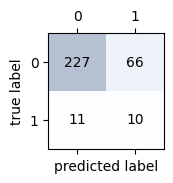

None
Accuracy = 0.755 |Sensitivity(recall) = 0.476 |Specificity = 0.775 |G-mean = 0.607 |MCC = 0.146
============================= Random Forest =============================


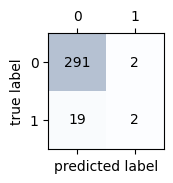

None
Accuracy = 0.933 |Sensitivity(recall) = 0.095 |Specificity = 0.993 |G-mean = 0.307 |MCC = 0.197
============================= SVM =============================


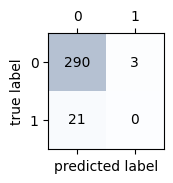

None
Accuracy = 0.924 |Sensitivity(recall) = 0.0 |Specificity = 0.99 |G-mean = 0.0 |MCC = -0.026
============================= XGBoost =============================


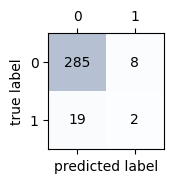

None
Accuracy = 0.914 |Sensitivity(recall) = 0.095 |Specificity = 0.973 |G-mean = 0.304 |MCC = 0.097
============================= KNN =============================


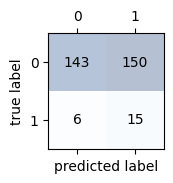

None
Accuracy = 0.503 |Sensitivity(recall) = 0.714 |Specificity = 0.488 |G-mean = 0.59 |MCC = 0.101
============================= Extra Tree =============================


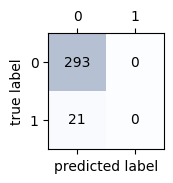

None
Accuracy = 0.933 |Sensitivity(recall) = 0.0 |Specificity = 1.0 |G-mean = 0.0 |MCC = nan
============================= Gradient Boosting =============================


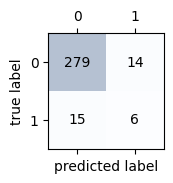

None
Accuracy = 0.908 |Sensitivity(recall) = 0.286 |Specificity = 0.952 |G-mean = 0.522 |MCC = 0.243
============================= lightGBM =============================


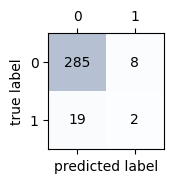

None
Accuracy = 0.914 |Sensitivity(recall) = 0.095 |Specificity = 0.973 |G-mean = 0.304 |MCC = 0.097
============================= CatBoost =============================


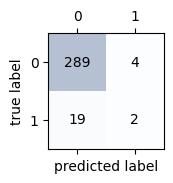

None
Accuracy = 0.927 |Sensitivity(recall) = 0.095 |Specificity = 0.986 |G-mean = 0.306 |MCC = 0.149
============================= MLP =============================


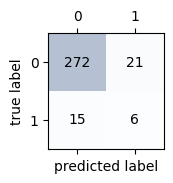

None
Accuracy = 0.885 |Sensitivity(recall) = 0.286 |Specificity = 0.928 |G-mean = 0.515 |MCC = 0.191


In [ ]:
classifiers = [LogisticRegression(),
        BalancedRandomForestClassifier(),
        SVC(),
        XGBClassifier(),
        KNeighborsClassifier(),
        ExtraTreesClassifier(),
        GradientBoostingClassifier(),
        LGBMClassifier(),
        CatBoostClassifier(logging_level='Silent'),
        MLPClassifier()]

Algorithm = ['LogisticRegression','Random Forest','SVM','XGBoost','KNN','Extra Tree','Gradient Boosting','lightGBM','CatBoost','MLP']
i = 0
for model in classifiers:
  print('=============================',Algorithm[i],'=============================')
  test_pred = model.fit(X_train_over,Y_train_over).predict(X_test)
  _,_,_,_,_,_ = Metric(y_test,test_pred)
  i += 1

## Modeling - Stratified 5 Fold cross validation

In [44]:
classifiers = [LogisticRegression(),
        BalancedRandomForestClassifier(),
        SVC(),
        XGBClassifier(),
        KNeighborsClassifier(),
        ExtraTreesClassifier(),
        GradientBoostingClassifier(),
        LGBMClassifier(),
        CatBoostClassifier(logging_level='Silent'),
        MLPClassifier()]

Algorithm = ['LogisticRegression','Random Forest','SVM','XGBoost','KNN','Extra Tree','Gradient Boosting','lightGBM','CatBoost','MLP']
i = 0
for classifier in classifiers:
  print('===================',Algorithm[i],'===================')
  _,_,_,_,_,_=cv_model(model = classifier , random_state= 42,n_splits = 5)
  i += 1

=================== LogisticRegression ===================
Sensitivity(Recall) = 0.441 | Specificity = 0.737 | G-means = 0.563 | MCC = 0.1 | accuracy = 0.717 | auc = 0.589
=================== Random Forest ===================
Sensitivity(Recall) = 0.019 | Specificity = 0.986 | G-means = 0.087 | MCC = 0.003 | accuracy = 0.921 | auc = 0.502
=================== SVM ===================
Sensitivity(Recall) = 0.039 | Specificity = 0.985 | G-means = 0.119 | MCC = 0.032 | accuracy = 0.922 | auc = 0.512
=================== XGBoost ===================
Sensitivity(Recall) = 0.038 | Specificity = 0.97 | G-means = 0.173 | MCC = 0.015 | accuracy = 0.908 | auc = 0.504
=================== KNN ===================
Sensitivity(Recall) = 0.682 | Specificity = 0.463 | G-means = 0.561 | MCC = 0.073 | accuracy = 0.478 | auc = 0.573
=================== Extra Tree ===================
Sensitivity(Recall) = 0.0 | Specificity = 1.0 | G-means = 0.0 | MCC = nan | accuracy = 0.934 | auc = 0.5
=================== Gra

### Select 5 model :
* Logistic regression
* XGBoost
* KNN
* Catboost
* Gradient Boosting

## Model Parameter Tuning and Prediction
We using Randomized grid Search to find the best hyperparameters

In [ ]:
# XGBoost 1
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000, step=200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'lambda': trial.suggest_float('lambda', 1e-6, 10.0),
        'alpha': trial.suggest_float('alpha', 1e-6, 10.0),
       'subsample': trial.suggest_float('subsample', 0.5, 1.0),
       'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
       'max_depth': trial.suggest_int('max_depth', 3, 10),
       'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'eta': trial.suggest_float('eta', 1e-8, 1.0),
       'gamma': trial.suggest_float('gamma', 1e-8, 1.0),

    }

    model = XGBClassifier(random_state=42, **params)

    # Perform k-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_index, valid_index in skf.split(scaled_feature, df_label):
        train_x = scaled_feature.iloc[train_index,:]
        train_y = df_impute.iloc[train_index,:]['Pass/Fail']

        valid_x = scaled_feature.iloc[valid_index,:]
        valid_y = df_impute.iloc[valid_index,:]['Pass/Fail']

        X_train_over, Y_train_over = BorderlineSMOTE(sampling_strategy=1).fit_resample(train_x, train_y)
        model.fit(X_train_over, Y_train_over)

        y_val_pred = model.predict(valid_x)
        cm = confusion_matrix(valid_y, y_val_pred)
        recall = cm[1][1] /(cm[1][1]+cm[1][0]) # recall
        scores.append(recall)

    avg_score = sum(scores) / len(scores)

    return avg_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

best_params = study.best_params
best_score = study.best_value

print("Best params:", best_params)
print("Best recall score:", best_score)

# Best params: {'n_estimators': 100, 'learning_rate': 0.028038473312228238, 'lambda': 1.208619094489733, 'alpha': 6.079355189865556, 'subsample': 0.917011600695461, 'colsample_bytree': 0.5493794416359443, 'max_depth': 3, 'min_child_weight': 2, 'eta': 0.6792449471806923, 'gamma': 0.2818459866718011}
# Best recall score: 0.4033333333333333

[I 2023-07-25 19:18:29,644] A new study created in memory with name: no-name-223fd4f0-d1c7-46a5-84c3-1005f09b199e
[I 2023-07-25 19:19:12,429] Trial 0 finished with value: 0.07666666666666666 and parameters: {'n_estimators': 1700, 'learning_rate': 0.07415539622471788, 'lambda': 5.800482872779111, 'alpha': 2.682756257890863, 'subsample': 0.6084767879912651, 'colsample_bytree': 0.5669428573012001, 'max_depth': 4, 'min_child_weight': 2, 'eta': 0.5410311549734135, 'gamma': 0.4299521201799365}. Best is trial 0 with value: 0.07666666666666666.
[I 2023-07-25 19:20:20,299] Trial 1 finished with value: 0.14428571428571427 and parameters: {'n_estimators': 1900, 'learning_rate': 0.03860516984195194, 'lambda': 3.322505259938804, 'alpha': 8.970870703163751, 'subsample': 0.9267094580861713, 'colsample_bytree': 0.7018967942109329, 'max_depth': 5, 'min_child_weight': 2, 'eta': 0.09966360071776649, 'gamma': 0.7466014403860192}. Best is trial 1 with value: 0.14428571428571427.
[I 2023-07-25 19:21:12,908]

Best params: {'n_estimators': 100, 'learning_rate': 0.028038473312228238, 'lambda': 1.208619094489733, 'alpha': 6.079355189865556, 'subsample': 0.917011600695461, 'colsample_bytree': 0.5493794416359443, 'max_depth': 3, 'min_child_weight': 2, 'eta': 0.6792449471806923, 'gamma': 0.2818459866718011}
Best recall score: 0.4033333333333333


In [ ]:
# CatBoost 1
def objective(trial):

    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-6, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 10.0),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'random_state': 42,
    }

    model = CatBoostClassifier(**params, auto_class_weights='Balanced')

    # Perform k-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_index, valid_index in skf.split(scaled_feature, df_label):
        train_x = scaled_feature.iloc[train_index,:]
        train_y = df_impute.iloc[train_index,:]['Pass/Fail']

        valid_x = scaled_feature.iloc[valid_index,:]
        valid_y = df_impute.iloc[valid_index,:]['Pass/Fail']

        X_train_over, Y_train_over = BorderlineSMOTE(sampling_strategy=1).fit_resample(train_x, train_y)
        model.fit(X_train_over, Y_train_over,verbose = False)

        y_val_pred = model.predict(valid_x)
        cm = confusion_matrix(valid_y, y_val_pred)
        recall = cm[1][1] /(cm[1][1]+cm[1][0]) # recall
        scores.append(recall)

    avg_score = sum(scores) / len(scores)

    return avg_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

best_params = study.best_params
best_score = study.best_value

print("Best params:", best_params)
print("Best recall score:", best_score)

# Best params: {'iterations': 500, 'learning_rate': 0.01027086631849947, 'depth': 3, 'l2_leaf_reg': 7.727513266068814, 'bagging_temperature': 3.4323289112268, 'random_strength': 9.9560750101214, 'border_count': 206}
# Best recall score: 0.3838095238095238

[I 2023-07-25 20:04:33,686] A new study created in memory with name: no-name-89e5ffc2-589b-415a-92de-8cd185f36edd
[I 2023-07-25 20:04:35,504] Trial 0 finished with value: 0.19142857142857142 and parameters: {'iterations': 100, 'learning_rate': 0.08213631915227049, 'depth': 4, 'l2_leaf_reg': 6.891964281217621, 'bagging_temperature': 5.135423240037933, 'random_strength': 0.4859378299362449, 'border_count': 78}. Best is trial 0 with value: 0.19142857142857142.
[I 2023-07-25 20:05:50,986] Trial 1 finished with value: 0.02857142857142857 and parameters: {'iterations': 800, 'learning_rate': 0.0243802881719061, 'depth': 9, 'l2_leaf_reg': 4.221173884830766, 'bagging_temperature': 8.096699144322697, 'random_strength': 2.514484838712907, 'border_count': 68}. Best is trial 0 with value: 0.19142857142857142.
[I 2023-07-25 20:06:21,856] Trial 2 finished with value: 0.05714285714285714 and parameters: {'iterations': 400, 'learning_rate': 0.03539579609085077, 'depth': 8, 'l2_leaf_reg': 6.988042252460

Best params: {'iterations': 500, 'learning_rate': 0.01027086631849947, 'depth': 3, 'l2_leaf_reg': 7.727513266068814, 'bagging_temperature': 3.4323289112268, 'random_strength': 9.9560750101214, 'border_count': 206}
Best recall score: 0.3838095238095238


## Gradient Boost Decision Tree

In [37]:
 # CatBoost 1
def objective(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000, step=200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_samples_split':trial.suggest_int('min_samples_split', 10,500),
        'min_samples_leaf':trial.suggest_int('min_samples_leaf', 1,100),
        'random_state': 42,
    }
    model = GradientBoostingClassifier(**params)

    # Perform k-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_index, valid_index in skf.split(scaled_feature, df_label):
        train_x = scaled_feature.iloc[train_index,:]
        train_y = df_impute.iloc[train_index,:]['Pass/Fail']

        valid_x = scaled_feature.iloc[valid_index,:]
        valid_y = df_impute.iloc[valid_index,:]['Pass/Fail']

        X_train_over, Y_train_over = BorderlineSMOTE(sampling_strategy=1).fit_resample(train_x, train_y)
        model.fit(X_train_over, Y_train_over)

        y_val_pred = model.predict(valid_x)
        cm = confusion_matrix(valid_y, y_val_pred)
        recall = cm[1][1] /(cm[1][1]+cm[1][0]) # recall
        scores.append(recall)

    avg_score = sum(scores) / len(scores)

    return avg_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

best_params = study.best_params
best_score = study.best_value

print("Best params:", best_params)
print("Best recall score:", best_score)

# Best params: {'n_estimators': 100, 'learning_rate': 0.08842028276441474, 'depth': 10, 'subsample': 0.9595014977920548, 'min_samples_split': 800}
# Best recall score: 0.48952380952380947

[I 2023-07-31 15:30:04,608] A new study created in memory with name: no-name-da1c2ed6-0d4c-498c-ac03-25e8c1de1e83
[I 2023-07-31 15:30:37,170] Trial 0 finished with value: 0.16333333333333333 and parameters: {'n_estimators': 300, 'learning_rate': 0.029124047810446467, 'max_depth': 14, 'subsample': 0.7358285517133583, 'min_samples_split': 447, 'min_samples_leaf': 68}. Best is trial 0 with value: 0.16333333333333333.
[I 2023-07-31 15:32:57,249] Trial 1 finished with value: 0.06666666666666667 and parameters: {'n_estimators': 1100, 'learning_rate': 0.012235370729698485, 'max_depth': 20, 'subsample': 0.7679866974094056, 'min_samples_split': 487, 'min_samples_leaf': 34}. Best is trial 0 with value: 0.16333333333333333.
[I 2023-07-31 15:37:39,924] Trial 2 finished with value: 0.02857142857142857 and parameters: {'n_estimators': 1900, 'learning_rate': 0.026993032789327798, 'max_depth': 10, 'subsample': 0.7185044073210726, 'min_samples_split': 250, 'min_samples_leaf': 35}. Best is trial 0 with 

Best params: {'n_estimators': 100, 'learning_rate': 0.02131054682263109, 'max_depth': 19, 'subsample': 0.5793402857038504, 'min_samples_split': 133, 'min_samples_leaf': 93}
Best recall score: 0.28857142857142853


### Logistic regression

In [ ]:
# LR 1
def objective(trial):

    params = {
        'C': trial.suggest_float('C', 500, 2000),
        'max_iter': trial.suggest_int('max_iter', 500, 1500),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced']),
        'solver': trial.suggest_categorical('solver', ['liblinear','sag','lbfgs','newton-cg']),
    }

    model = LogisticRegression(**params)

    # Perform k-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_index, valid_index in skf.split(scaled_feature, df_label):
        train_x = scaled_feature.iloc[train_index,:]
        train_y = df_impute.iloc[train_index,:]['Pass/Fail']

        valid_x = scaled_feature.iloc[valid_index,:]
        valid_y = df_impute.iloc[valid_index,:]['Pass/Fail']

        X_train_over, Y_train_over = BorderlineSMOTE(sampling_strategy=1).fit_resample(train_x, train_y)
        model.fit(X_train_over, Y_train_over)

        y_val_pred = model.predict(valid_x)
        cm = confusion_matrix(valid_y, y_val_pred)
        recall = cm[1][1] /(cm[1][1]+cm[1][0]) # recall
        scores.append(recall)

    avg_score = sum(scores) / len(scores)

    return avg_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_score = study.best_value

print("Best params:", best_params)
print("Best recall score:", best_score)

# Best params: {'C': 952.3036792683072, 'max_iter': 538, 'class_weight': 'balanced', 'solver': 'newton-cg'}
# Best recall score: 0.4790476190476191

[I 2023-07-26 11:33:56,066] A new study created in memory with name: no-name-e9ab0ec0-ba32-4d96-9acd-5a25a9d7daf5
[I 2023-07-26 11:33:57,123] Trial 0 finished with value: 0.42142857142857143 and parameters: {'C': 1279.7563606888536, 'max_iter': 994, 'class_weight': 'balanced', 'solver': 'newton-cg'}. Best is trial 0 with value: 0.42142857142857143.
[I 2023-07-26 11:33:58,499] Trial 1 finished with value: 0.4309523809523809 and parameters: {'C': 996.0645107266349, 'max_iter': 510, 'class_weight': 'balanced', 'solver': 'newton-cg'}. Best is trial 1 with value: 0.4309523809523809.
[I 2023-07-26 11:33:59,848] Trial 2 finished with value: 0.4314285714285714 and parameters: {'C': 729.603247387464, 'max_iter': 988, 'class_weight': 'balanced', 'solver': 'newton-cg'}. Best is trial 2 with value: 0.4314285714285714.
[I 2023-07-26 11:34:01,021] Trial 3 finished with value: 0.4314285714285714 and parameters: {'C': 1521.3075374392633, 'max_iter': 735, 'class_weight': 'balanced', 'solver': 'liblinea

Best params: {'C': 1744.1660621864212, 'max_iter': 1380, 'class_weight': 'balanced', 'solver': 'liblinear'}
Best recall score: 0.48904761904761906


### KNN

In [ ]:
# KNN 1
def objective(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 2,100),
        'leaf_size': trial.suggest_int('max_iter', 5, 100),
        'algorithm': trial.suggest_categorical('algorithm', ['ball_tree','kd_tree','brute'] ),
        'weights' : trial.suggest_categorical('weights',['uniform', 'distance']),
    }

    model = KNeighborsClassifier(**params)

    # Perform k-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_index, valid_index in skf.split(scaled_feature, df_label):
        train_x = scaled_feature.iloc[train_index,:]
        train_y = df_impute.iloc[train_index,:]['Pass/Fail']

        valid_x = scaled_feature.iloc[valid_index,:]
        valid_y = df_impute.iloc[valid_index,:]['Pass/Fail']

        X_train_over, Y_train_over = BorderlineSMOTE(sampling_strategy=1).fit_resample(train_x, train_y)
        model.fit(X_train_over, Y_train_over)

        y_val_pred = model.predict(valid_x)
        acc = accuracy_score(valid_y, y_val_pred)
        scores.append(acc)

    avg_score = sum(scores) / len(scores)

    return avg_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_score = study.best_value

print("Best params:", best_params)
print("Best acc score:", best_score)

# Best params: {'n_neighbors': 2, 'max_iter': 94, 'algorithm': 'brute', 'weights': 'distance'}
# Best acc score: 0.6528275777863699

[I 2023-07-30 19:53:09,667] A new study created in memory with name: no-name-7e04807c-c084-402a-85df-219a11eee6a1
[I 2023-07-30 19:53:10,340] Trial 0 finished with value: 0.2820455424187542 and parameters: {'n_neighbors': 26, 'max_iter': 81, 'algorithm': 'brute', 'weights': 'uniform'}. Best is trial 0 with value: 0.2820455424187542.
[I 2023-07-30 19:53:11,537] Trial 1 finished with value: 0.26099183980789975 and parameters: {'n_neighbors': 29, 'max_iter': 20, 'algorithm': 'ball_tree', 'weights': 'distance'}. Best is trial 0 with value: 0.2820455424187542.
[I 2023-07-30 19:53:15,671] Trial 2 finished with value: 0.2973749007956696 and parameters: {'n_neighbors': 24, 'max_iter': 9, 'algorithm': 'kd_tree', 'weights': 'distance'}. Best is trial 2 with value: 0.2973749007956696.
[I 2023-07-30 19:53:17,663] Trial 3 finished with value: 0.1767546447976232 and parameters: {'n_neighbors': 82, 'max_iter': 22, 'algorithm': 'brute', 'weights': 'distance'}. Best is trial 2 with value: 0.29737490079

Best params: {'n_neighbors': 2, 'max_iter': 94, 'algorithm': 'brute', 'weights': 'distance'}
Best acc score: 0.6528275777863699


## Ensemble Voting

Testing data soft vote result : 


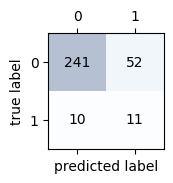

None
Accuracy = 0.803 |Sensitivity(recall) = 0.524 |Specificity = 0.823 |G-mean = 0.657 |MCC = 0.216
Testing data hard vote result : 


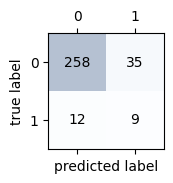

None
Accuracy = 0.85 |Sensitivity(recall) = 0.429 |Specificity = 0.881 |G-mean = 0.615 |MCC = 0.222


In [47]:
LR = LogisticRegression(C=1744.1660621864212, max_iter= 1380, class_weight='balanced',solver='liblinear')

GBDT = GradientBoostingClassifier(n_estimators=100, learning_rate= 0.02131054682263109, max_depth=19,
                  subsample=0.5793402857038504, min_samples_split=133,min_samples_leaf=93,random_state=42)

KNN = KNeighborsClassifier(n_neighbors= 2, leaf_size=94, algorithm= 'brute', weights= 'distance')

Catboost = CatBoostClassifier( logging_level='Silent',iterations=500,learning_rate=0.01027086631849947,depth=3,l2_leaf_reg=7.727513266068814,
            bagging_temperature= 3.4323289112268,random_strength=9.9560750101214,border_count=206, auto_class_weights='Balanced',random_state=42)

Xgboost = XGBClassifier(n_estimators = 100,learning_rate=0.028038473312228238,alpha=6.079355189865556,subsample=0.917011600695461
            ,colsample_bytree=0.5493794416359443,max_depth=3,min_child_weight=2,eta=0.6792449471806923,gamma=0.2818459866718011,random_state=42)

soft_vote = VotingClassifier(estimators=[('lr', LR),  ('gbdt', GBDT),('knn',KNN),('cat',Catboost),('xgb',Xgboost)], voting='soft')
hard_vote = VotingClassifier(estimators=[('lr', LR),  ('gbdt', GBDT),('knn',KNN),('cat',Catboost),('xgb',Xgboost)], voting='hard')

predictions = soft_vote.fit(X_train_over,Y_train_over).predict(X_test)
print('Testing data soft vote result : ')
_,_,_,_,_,_ = Metric(y_test, predictions)

predictions = hard_vote.fit(X_train_over, Y_train_over).predict(X_test)
print('Testing data hard vote result : ')
_,_,_,_,_,_ = Metric(y_test, predictions)

In [39]:
data = np.random.randint(1, 100, size=(7, 7))
result_df = pd.DataFrame(data,columns=['Model','Recall','Specificity','G-means','MCC','Accuracy','AUC'])
result_df['Model'] = ['LR','KNN','GBDT','Catboost','XGBoost','Soft Voting Classifier','Hard Voting Classifier']

In [43]:
LR = LogisticRegression(C=1744.1660621864212, max_iter= 1380, class_weight='balanced',solver='liblinear')

GBDT = GradientBoostingClassifier(n_estimators=100, learning_rate= 0.02131054682263109, max_depth=19,
                  subsample=0.5793402857038504, min_samples_split=133,min_samples_leaf=93,random_state=42)

KNN = KNeighborsClassifier(n_neighbors= 2, leaf_size=94, algorithm= 'brute', weights= 'distance')

Catboost = CatBoostClassifier( logging_level='Silent',iterations=500,learning_rate=0.01027086631849947,depth=3,l2_leaf_reg=7.727513266068814,
            bagging_temperature= 3.4323289112268,random_strength=9.9560750101214,border_count=206, auto_class_weights='Balanced',random_state=42)

Xgboost = XGBClassifier(n_estimators = 100,learning_rate=0.028038473312228238,alpha=6.079355189865556,subsample=0.917011600695461
            ,colsample_bytree=0.5493794416359443,max_depth=3,min_child_weight=2,eta=0.6792449471806923,gamma=0.2818459866718011,random_state=42)

soft_vote = VotingClassifier(estimators=[('lr', LR), ('lr2', LR), ('gbdt', GBDT),('knn',KNN),('cat',Catboost),('xgb',Xgboost)], voting='soft')
hard_vote = VotingClassifier(estimators=[('lr', LR), ('lr2', LR), ('gbdt', GBDT),('knn',KNN),('cat',Catboost),('xgb',Xgboost)], voting='hard')

models = [LR,KNN,GBDT,Catboost,Xgboost,soft_vote,hard_vote]

model_name = ['LR','KNN','GBDT','Catboost','XGBoost','Soft Voting Classifier','Hard Voting Classifier']
i = 0
for classifier in models:
  print('===================',model_name[i],'===================')
  result_df.iloc[i,1:] = cv_model(model = classifier , random_state=12)
  i += 1

=================== LR ===================
Sensitivity(Recall) = 0.462 | Specificity = 0.754 | G-means = 0.587 | MCC = 0.123 | accuracy = 0.735 | auc = 0.608
=================== KNN ===================
Sensitivity(Recall) = 0.442 | Specificity = 0.655 | G-means = 0.531 | MCC = 0.05 | accuracy = 0.641 | auc = 0.548
=================== GBDT ===================
Sensitivity(Recall) = 0.28 | Specificity = 0.879 | G-means = 0.484 | MCC = 0.118 | accuracy = 0.839 | auc = 0.58
=================== Catboost ===================
Sensitivity(Recall) = 0.338 | Specificity = 0.859 | G-means = 0.536 | MCC = 0.137 | accuracy = 0.825 | auc = 0.598
=================== XGBoost ===================
Sensitivity(Recall) = 0.482 | Specificity = 0.843 | G-means = 0.635 | MCC = 0.214 | accuracy = 0.819 | auc = 0.663
=================== Soft Voting Classifier ===================
Sensitivity(Recall) = 0.414 | Specificity = 0.815 | G-means = 0.578 | MCC = 0.143 | accuracy = 0.788 | auc = 0.614
=================== H

In [49]:
result_df.to_csv("result.csv")

## Results
* Through the oversampling method(SMOTE), we can solve the problem of training data set  is imbalance.
* Accuracy is not an appropriate metric when evaluating imbalanced datasets.
* Compared with other models, rotation forest is the most effective model to solve this imbalanced  secom dataset.

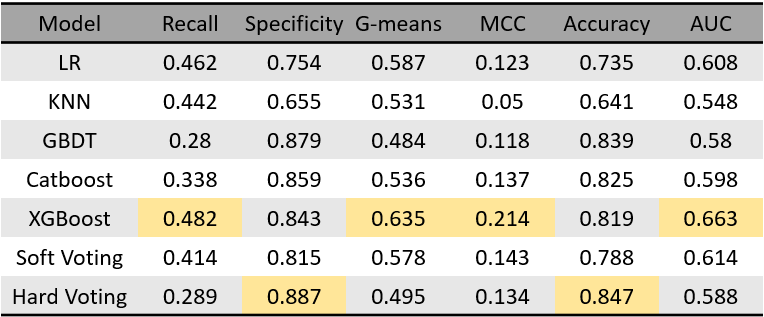